In [1]:
import numpy as np
from skimage import io
import sys
import os

In [2]:
imgs_train_set = [] #46*56
imgs_test_set = []
label_train = []
label_test = []
img_8_1 = 0 
index_img_8_1 = 0

In [3]:
for i, filename in enumerate(os.listdir('./p1_data')):
    img = io.imread('./p1_data/' + filename)
    img = img.flatten()
    if not filename.endswith('10.png'):
        imgs_train_set.append(img)
        l = filename.split('_')[0]
        label_train.append(int(l))
        if filename == '8_1.png':
            img_8_1 = img
            index_img_8_1 = len(imgs_train_set)-1
    else:
        imgs_test_set.append(img)
        l = filename.split('_')[0]
        label_test.append(int(l))


imgs_train_set = np.array(imgs_train_set).astype('float64')
imgs_test_set = np.array(imgs_test_set).astype('float64')
label_train = np.array(label_train) - 1
label_test = np.array(label_test) - 1
print(imgs_train_set.shape, imgs_test_set.shape)
print(label_train.shape, label_test.shape)
print(index_img_8_1)

(360, 2576) (40, 2576)
(360,) (40,)
342


In [4]:
def plot_face(i,filename, norm = False):
    if norm:
        i -= np.min(i)
        i /= np.max(i)
        i = (i*255).astype(np.uint8)
    else:
        i = (i).astype(np.uint8)
    io.imshow(i.reshape((56,46)))
    io.show()
    io.imsave('{}.jpg'.format(filename),i.reshape((56,46)))

In [5]:
def mean_face(imgs):
    imgs_mean = np.mean(imgs,axis=0)
    return imgs_mean

In [6]:
imgs_mean = mean_face(imgs_train_set)
plot_face(imgs_mean,"mean_face")

<Figure size 640x480 with 1 Axes>

In [7]:
U, S, VT = np.linalg.svd(imgs_train_set - imgs_train_set.mean(0), full_matrices=False)
print(U.shape, S.shape, VT.shape)
first_four = VT[:4]

(360, 360) (360,) (360, 2576)


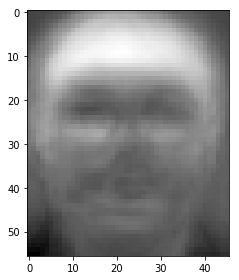

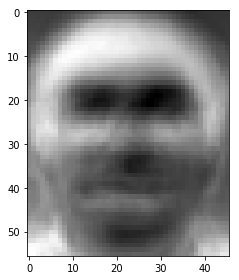

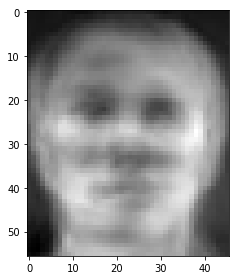

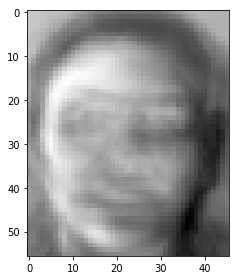

In [8]:
for i, img in enumerate(first_four):
    plot_face(img,'eigne_face_{}'.format(i),norm=True)

### Reconstruct Face

In [9]:
mean = np.mean(imgs_train_set, axis=0)
imgs_center = imgs_train_set - mean
u, s, vt = np.linalg.svd(imgs_center, full_matrices=False)
weights = np.dot(imgs_center, vt.T)
recons = []
for i in [3, 50, 170, 240, 345]:
    recon = mean + np.dot(weights[index_img_8_1, :i], vt[:i]) # person8image1.
    recons.append(recon)

In [10]:
recons = np.array(recons)
print(recons.shape)

(5, 2576)


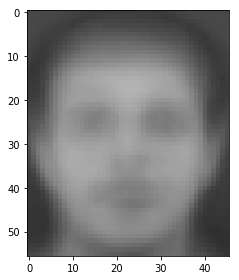

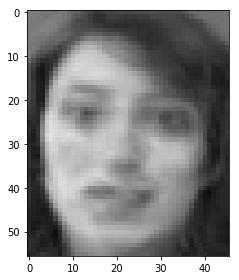

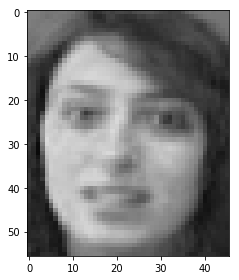

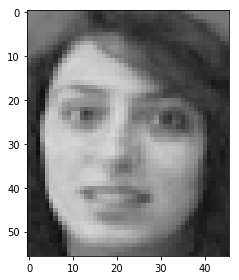

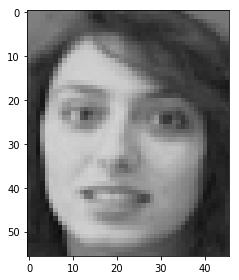

In [11]:
for i, recon in enumerate(recons):
    plot_face(recon,"recon_{}".format(i))

In [12]:
mses = []
for i, recon in enumerate(recons):
    error = np.sum((recon-img_8_1)**2/(56*46))
    mses.append(error)
print(mses)

[1566.347198469645, 134.0318326134111, 39.84704055061052, 21.47781777086208, 3.0422161755644983]


## kfold

In [13]:
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier

In [14]:
from sklearn.metrics import accuracy_score
def KNN(k,x_train, y_train, x_test, y_test):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    return accuracy_score(y_test, y_pred), knn

In [15]:
from sklearn.model_selection import KFold
def KFOLD(k, x ,y, x_test, y_test):
    kf = KFold(n_splits=3, shuffle=True, random_state=9527)
    
    scores = []
    models = []
    results = []
    for train_index, valid_index in kf.split(x):
        x_train, x_valid = x[train_index], x[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        valid_score, model = KNN(k, x_train, y_train, x_valid, y_valid)
        scores.append(valid_score)
        models.append(model)
        
        y_result = model.predict(x_test)
        results.append(accuracy_score(y_test, y_result))
        
    return np.mean(scores), np.mean(results),  models

In [16]:
print(imgs_train_set.shape, label_train.shape)

(360, 2576) (360,)


In [17]:
for i in [1, 3, 5]:
    valid_results = []
    test_results = []
    for j in [3, 5, 50, 170, 360]:
        imgs_center = imgs_train_set - imgs_train_set.mean(0)
        u, s, vt = np.linalg.svd(imgs_center, full_matrices=False)
        imgs_reduce = np.dot(imgs_center, vt.T)
        imgs_test_reduce = np.dot(imgs_test_set - imgs_train_set.mean(0), vt.T)
        
        valid_scores, test_scores, _ = KFOLD(i, imgs_reduce[:,:j], label_train, imgs_test_reduce[:,:j], label_test)
        
        valid_results.append(valid_scores)
        test_results.append(test_scores)
        
    print("k={} valid scores".format(i), valid_results)
    print("k={} test scores".format(i), test_results)    

k=1 valid scores [0.7277777777777779, 0.8222222222222223, 0.9666666666666667, 0.9666666666666667, 0.9694444444444444]
k=1 test scores [0.6749999999999999, 0.7583333333333334, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666]
k=3 valid scores [0.6166666666666667, 0.75, 0.9, 0.8944444444444445, 0.8944444444444445]
k=3 test scores [0.5583333333333333, 0.7333333333333333, 0.8583333333333334, 0.875, 0.8833333333333333]
k=5 valid scores [0.5416666666666666, 0.6583333333333333, 0.8583333333333334, 0.8388888888888889, 0.8472222222222223]
k=5 test scores [0.5416666666666667, 0.6333333333333333, 0.8083333333333332, 0.8000000000000002, 0.7916666666666666]


## PCA using sklearn

In [18]:
from sklearn.decomposition import PCA
random_state = 9527
pca_1d = PCA(5, random_state=random_state)
L = pca_1d.fit_transform(imgs_train_set) 

(360, 3)


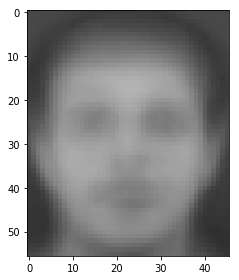

(360, 50)


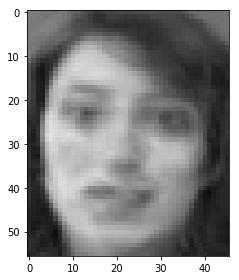

(360, 170)


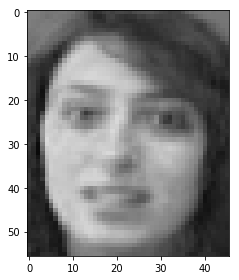

(360, 240)


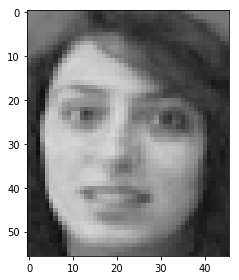

(360, 345)


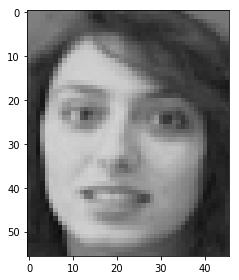

In [19]:
recons_sk = []
for n in [3, 50, 170, 240, 345]:
    pca_1d = PCA(n, svd_solver="full")
    L = pca_1d.fit_transform(imgs_train_set)
    print(L.shape)
    recon = pca_1d.inverse_transform(L[index_img_8_1].reshape(1, -1))
    recons_sk.append(recon)
    plot_face(recon,"recon_sk_{}".format(n))

In [20]:
mses_sk = []
for i, recon in enumerate(recons_sk):
    error = np.sum((recon-img_8_1)**2/(56*46))
    mses_sk.append(error)
print(mses_sk)

[1566.3471984696491, 134.03183261341115, 39.84704055061056, 21.477817770862075, 3.042216175564488]


In [21]:
from scipy import linalg
from sklearn.utils.extmath import svd_flip
from numpy.testing import assert_array_almost_equal
U, S, Vt = np.linalg.svd(imgs_train_set - imgs_train_set.mean(0), full_matrices=False)
# flip eigenvectors' sign to enforce deterministic output
U, Vt = svd_flip(U, Vt)

pca_ = PCA(30, svd_solver="full")
pca_.fit(imgs_train_set)
assert_array_almost_equal(Vt[:30], pca_.components_)